In [1]:
import numpy as np
from numba import jit #関数の高速化のライブラリ
import matplotlib.pyplot as plt

## 不等流計算

In [2]:
@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def nonuniformflow(q, hDB, zb, dx, manning, g=float(9.8)):
    h = np.zeros_like(zb) #水深の配列
    h[0] = hDB #下流端条件

    for i in range(1,len(h)):
    # newton法による反復計算
        # h[i] = h[i-1] + zb[i-1] - zb[i]#収束計算の初期値：一つ下流側の断面の水深
        # f = 1.0 #仮値
        # dfdh = 1.0 #仮値
        # while np.abs(f/dfdh) > 10**(-8): # 反復計算の収束条件
        #     f = q**2/2.0/g/h[i]**2 + h[i] + zb[i] \
        #       -(q**2/2.0/g/h[i-1]**2 + h[i-1] + zb[i-1]) \
        #       - 0.5*(q**2*manning**2/h[i]**(10/3) + q**2*manning**2/h[i-1]**(10/3))*dx
        #     dfdh = -q**2/g/h[i]**3 + 1 + 5/3*q**2*manning**2/h[i]**(13/3)*dx
        #     h[i] -= f/dfdh

    # 二分法による反復計算 : hcから徐々に上げていく
        hc = (q**2/g)**(1/3) # 限界水深 
        hp = hc
        E1 = q**2/2.0/g/hp**2 + hp + zb[i]
        E2 = + (q**2/2.0/g/h[i-1]**2 + h[i-1] + zb[i-1]) \
              + 0.5*(q**2*manning**2/hp**(10/3) + q**2*manning**2/h[i-1]**(10/3))*dx

        if E2 >= E1 : #常流時のみ計算, 射流時は限界水深に置き換え
        # 収束計算の初期値は限界水深+hmin:0.0001m
            hp += 0.0001
            dht = 0.1
            for _ in range(1000):
                E1 = q**2/2.0/g/hp**2 + hp + zb[i]
                E2 = + (q**2/2.0/g/h[i-1]**2 + h[i-1] + zb[i-1]) \
                      + 0.5*(q**2*manning**2/hp**(10/3) + q**2*manning**2/h[i-1]**(10/3))*dx
            
                if np.abs(E1 - E2) < 10**(-8): 
                    break
                elif E1 > E2 :
                    dht *= float(0.5)
                    hp -= dht
                else:
                    hp += dht
            else:
                print('error : max iteration - nonuniform flow sect No.', i, 'err=', np.abs(E1 - E2))

        h[i] = hp
        # print(h[i])
    return h

## 流砂量の計算

In [3]:
@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def calqb(h, q, manning, dm, tauc,g=float(9.8),rhosw=float(1.65)):
    qb = np.zeros_like(h)
    for i in range(len(h)):
        hp = h[i]
        us = np.sqrt(g)*manning*q/hp**(7/6) # 摩擦速度
        taus = us**2/rhosw/g/dm # 無次元掃流力

        if taus <= tauc : # 移動限界の判定
            qb[i] = 0.0
        else:
        # 有効掃流力：面倒なのであまり気にしない。
            Ar = 8.5
            kappa = 0.4
            if np.log(hp/dm/(1.0+2.0*taus)) < 1.0:
                phi = Ar
            else:
                phi = (np.log(hp/dm/(1.0+2.0*taus))-1.0)/kappa + Ar

            U = q/hp
            use = U/phi
            tauet = use**2/rhosw/g/dm
            taue = tauet if tauet < taus else taus

        # Ashida-Michiue Eq. 
            qb[i] = np.sqrt(rhosw*g*dm**3)*17.0*taue**1.5*(1.0-tauc/taus)*(1.0-np.sqrt(tauc/taus))
    return qb

## 河床の連続式の計算

In [4]:
@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def calzb(zb, qbhfp, dx, dt, porosity=0.4):
    # 河床の連続式を計算
    dzb = np.zeros(len(zb)) 
    for i in range(len(zb)):
        dzb[i] = - dt / (1.0 - porosity) * ( qbhfp[i+1] - qbhfp[i] )/dx

    zb += dzb #zbの更新
    return zb

## main

### 計算条件の設定

In [5]:
q = 5.0 #単位幅流量[m^2/s]
manning = 0.02 #マニングの粗度係数
dm = 5/1000 #粒径[m]o
dx = 100.0 #空間刻み[m] 
dt = 10.0 #時間刻み[s]

# 河床高の設定
ib = 1.0/700.0
L = np.arange(0,10000.01,dx) #追加距離の配列
zbr = L*ib #河床高の配列
zb  = zbr[::-1]

### 水理量のチェック

In [6]:
h0 = (q**2*manning**2/ib)**0.3 #等流水深
hc = (q**2/9.8)**(1/3) # 限界水深 
fr = q/h0/np.sqrt(9.8*h0)
taus = h0*ib/1.65/dm
print('下流端条件-','水深：',h0, 'Froude数:', fr, '無次元掃流力:', taus)

下流端条件- 水深： 1.792789962520997 Froude数: 0.6653694374950128 無次元掃流力: 0.3104398203499562


### 初期河床高を設定

In [7]:
# 河道中央付近にマウンドを設定
imd = len(zb)//2
zbsub = np.zeros_like(zb)
zbsub[imd:imd+2] = 0.5 #中央付近の河床高に0.5mの凸を追加
zbsub[imd-1] = zbsub[imd+2] = 0.4 #擦り付け
zbsub[imd-2] = zbsub[imd+3] = 0.3 #擦り付け
zbsub[imd-3] = zbsub[imd+4] = 0.2 #擦り付け
zbsub[imd-4] = zbsub[imd+5] = 0.1 #擦り付け

zb += zbsub #初期河床高

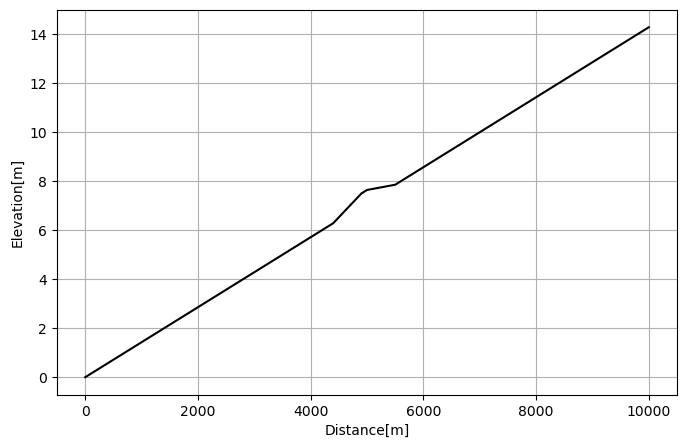

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(L, zb[::-1], label='zb', color='k')
ax.set_xlabel('Distance[m]')
ax.set_ylabel('Elevation[m]')
ax.grid()

### 河床変動計算

In [9]:
%%time
istep = int(5.0*3600.0/dt) #計算時間：5時間のステップ数

zbini = zb.copy() #初期河床高の保存
for itr in range(istep):
    hDB = h0 #下流端の水深
    zbr = zb[::-1] #不等流計算用に逆順にする
    hr = nonuniformflow(q, hDB, zbr, dx, manning) # 不等流計算

    h = hr[::-1] #不等流計算結果が逆順になっているので元に戻す
    if itr==0: hini = h.copy() #初期水深の保存

    # 流砂量の計算 
    # 岩垣の式等による無次元限界掃流力の計算が必要ですが、砂礫の計算のため0.05でO.K.
    qb = calqb(h, q, manning, dm, tauc=0.05)

    # 河床高の計算
    # ハーフセルの値を設定 : スタッガードスキーム
    # 配列のインデックスは、i-1/2⇒i,i+1/2⇒i+1と定義する
    qbhf = np.zeros(len(h)+1)
    qbhf[1:] = qb[:] #風上化（一次元の場合、逆流は考えないとするとiの値を⇒i+1/2に代入する）
    qbhf[0] = qb[0] #上流端境界条件平衡給砂
    zb = calzb(zb,qbhf,dx, dt) # 河床高の更新

CPU times: total: 375 ms
Wall time: 1.36 s


## 図化

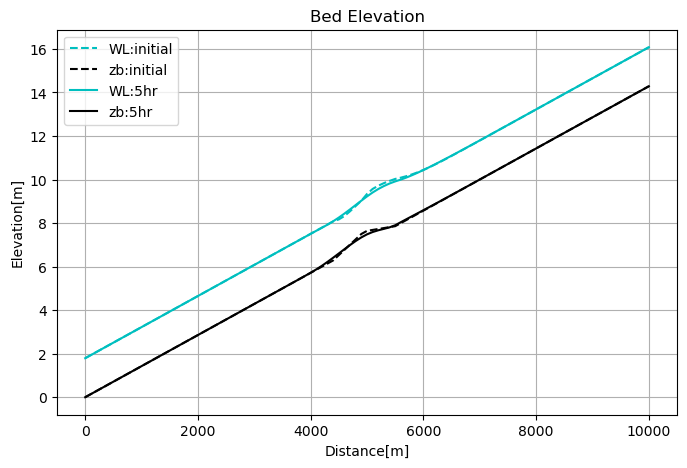

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(L, hini[::-1] + zbini[::-1], label='WL:initial', color='c', linestyle='dashed')
ax.plot(L, zbini[::-1], label='zb:initial', color='k', linestyle='dashed')
ax.plot(L, h[::-1] + zb[::-1], label='WL:5hr', color='c')
ax.plot(L, zb[::-1], label='zb:5hr', color='k')

ax.set_xlabel('Distance[m]')
ax.set_ylabel('Elevation[m]')
ax.set_title('Bed Elevation')
ax.grid(True)
ax.legend()